## Assigment: Neural network basics

Soft deadline: 16.09.18 at 23.59

Hard deadline: 18.09.18 at 23.59

For this task I intentionally provide no boilerplate code, because very puprpose of this task is getting you comforatable with basic code template for desiging NNs in pytorch. I higly recommend you to revisit all the last seminar materials.

#### Task

* Implement simple **fully-convolutional** neural architecture for classification. Make sure it is small enought to run on your home machine.
* Provide dataset visulization.
* Provide train/test split and validation

#### Requirements

* Architecture should derive from `torch.nn.Module`
* Use `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`. But if you manage co simplify this step using dataset `torchivision`, I will only encourage you.
* Implement at least one data transformer, but make sure it is useful for classification task.
* Use FashionMNIST dataset https://github.com/zalandoresearch/fashion-mnist
* Make sure you can fix random seed for all components of your code to make experiments reproducible
* Since you architecure should be fully-convolutional, make sure it does not depend on input size.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor, Normalize, Compose
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.nn.functional import relu
from torch.nn import Module, Softmax, Dropout, Conv2d, BatchNorm1d, BatchNorm2d, MaxPool2d, Linear, CrossEntropyLoss
from torch.optim import Adam
from torch.nn.modules.activation import ReLU

import numpy as np
from tensorboardX import SummaryWriter

In [2]:
torch.manual_seed(0)
datafolder = './data'
train_dataset = FashionMNIST(datafolder, train=True, 
                        download=True, transform = Compose([
                            ToTensor(),
                            Normalize((0.1307,), (0.3081,))
                        ]))
test_dataset = FashionMNIST(datafolder, train=False, 
                        download=True, transform = Compose([
                            ToTensor(),
                            Normalize((0.1307,), (0.3081,))
                        ]))
writer = SummaryWriter()

In [3]:
print(train_dataset)
print(test_dataset)

Dataset FashionMNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.1307,), std=(0.3081,))
                         )
    Target Transforms (if any): None
Dataset FashionMNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ./data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.1307,), std=(0.3081,))
                         )
    Target Transforms (if any): None


In [4]:
batch_size=100
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, shuffle=False)

In [5]:
label_dict = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

In [6]:
images = test_dataset.test_data[:200].float()
label = [ label_dict[test_dataset.test_labels[i].item()] for i in range(200) ]
features = images.view(200, 784)
writer.add_embedding(features, metadata=label, label_img=images.unsqueeze(1))

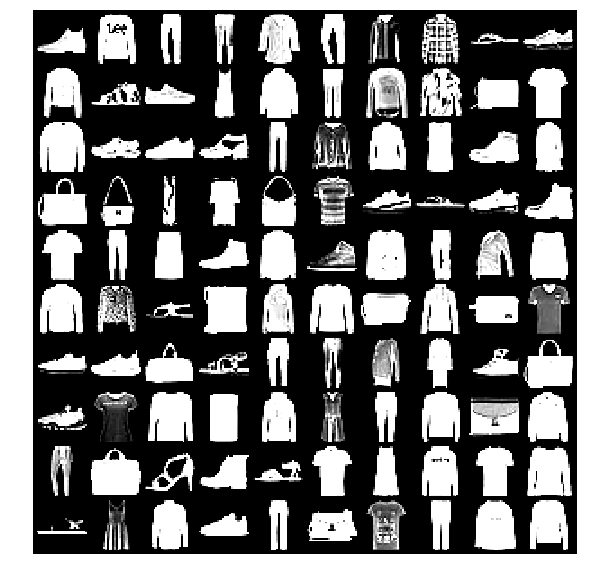

In [7]:
def imshow(img):
    img = torchvision.utils.make_grid(img, nrow=10, range=(-1., 1.))
    npimg = img.numpy()
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.axis('off')
    ax.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')

for images, _ in test_loader:
    imshow(images)
    break

In [8]:
class CNNModel(Module):
    padding = 1
    kernel = 3
    batch_kernel = 2
    
    def __init__ (self, output_dim=10):
        super(CNNModel, self).__init__()
        
        self.conv = torch.nn.Sequential(
            Conv2d(in_channels=1, out_channels=16, 
                   kernel_size=self.kernel, padding=self.padding),
            BatchNorm2d(16),
            MaxPool2d(kernel_size=self.batch_kernel),
            ReLU(),
            Conv2d(in_channels=16, out_channels=32, 
                   kernel_size=self.kernel, padding=self.padding),
            BatchNorm2d(32),
            MaxPool2d(kernel_size=self.batch_kernel),
            ReLU(),
            Conv2d(in_channels=32,out_channels=64, 
                   kernel_size=self.kernel, padding=self.padding),
            Dropout(),
            BatchNorm2d(64),
            MaxPool2d(kernel_size=self.batch_kernel),
            ReLU()
        )
        
        self.fc = torch.nn.Sequential(
            Linear(64 * 3 * 3, 200),
            BatchNorm1d(200),
            ReLU(),
            Dropout(),
            Linear(200, 50),
            BatchNorm1d(50),
            ReLU(),
            Linear(50, 10)
        )
        
    def forward(self, x):
        x = self.conv.forward(x)
        x = x.view(-1, 64 * 3 * 3)
        return self.fc.forward(x)

In [9]:
def train(model, loss, optimizer, x_val, y_val):
    x = Variable(x_val, requires_grad=False)
    y = Variable(y_val, requires_grad=False)

    optimizer.zero_grad()
    fx = model.forward(x)
    
    output = loss.forward(fx, y)
    output.backward()
    optimizer.step()
    
def predict(model, x_val):
    x = Variable(x_val, requires_grad=False)
    output = model.forward(x)
    return output.data.numpy().argmax(axis=1)

def count_loss(model, loss, dataset):
    with torch.no_grad():
        total = 0
        for in_batch, out_batch in dataset:
            total += loss.forward(model.forward(in_batch), out_batch).item()
    print(total / len(dataset.dataset), end=' ')
    return total / len(dataset.dataset)

In [11]:
model = CNNModel(output_dim=10)
loss = CrossEntropyLoss(size_average=True)
optimizer = Adam(model.parameters(), lr=0.01)
n_epochs = 30
accuracy = []
train_losses = []
test_losses = []

for i in range(n_epochs):
    for input_batch, output_batch in train_loader:
        train(model, loss, optimizer, input_batch, output_batch)
    acc = 0
    for input_batch, output_batch in test_loader:
        predicted = predict(model, input_batch)
        acc += torch.sum(predicted == output_batch)
    accuracy.append(100. * acc / len(test_loader.dataset))
    train_losses.append(count_loss(model, loss, train_loader))
    test_losses.append(count_loss(model, loss, test_loader))
    
    print("Epoch {}, acc = {}%, ".format(i + 1, accuracy[-1]))
    
plt.plot(accuracy, label="accuracy")
plt.legend()
plt.show()

plt.plot(train_losses, label='Train loss')
plt.plot(test_losses, label='Test loss')
plt.legend()
plt.show()

/home/fedannie/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


0.00372825315023462 0.004008248052001 Epoch 1, acc = 85%, 


KeyboardInterrupt: 